In [1]:
from sentence_transformers import SentenceTransformer, util, InputExample, losses
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.chat_models import ChatOllama
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np
import umap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import tiktoken
import pandas as pd


c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
model = SentenceTransformer('all-MiniLM-L6-v2')

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
loader = DirectoryLoader('data', glob="**/*.txt")
docs = loader.load()

In [4]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)

In [5]:
docs = text_splitter.split_documents(docs)
texts = [doc.page_content for doc in docs]

In [6]:
def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [7]:
counts = [num_tokens_from_string(t) for t in texts]


<function matplotlib.pyplot.show(close=None, block=None)>

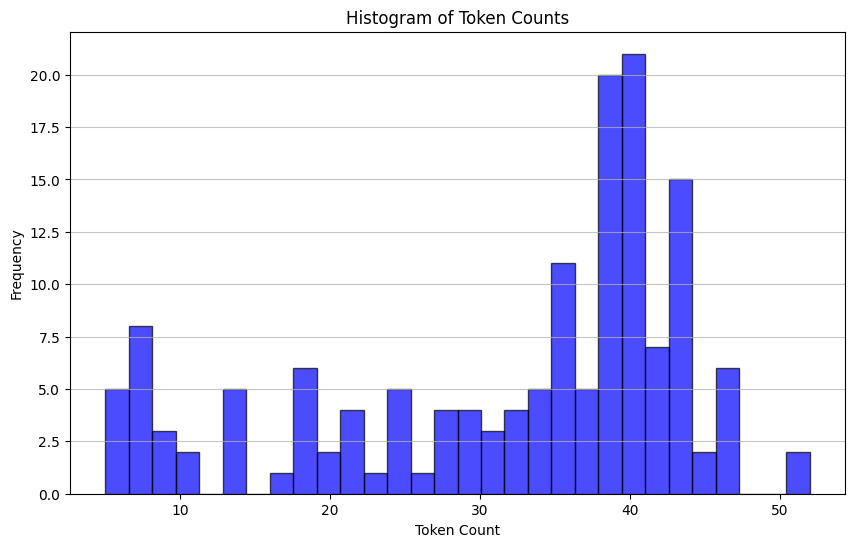

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show

In [9]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 5250


In [10]:
global_embeddings = [model.encode(txt) for txt in texts]

In [11]:
def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


dim = 10
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)
global_embeddings_reduced[0]

array([ 6.0182924 ,  0.25438383,  3.69432   ,  3.1313214 , 12.159335  ,
        5.8155184 ,  0.95078725, 11.425721  ,  4.0267787 ,  4.6272097 ],
      dtype=float32)

In [12]:
def get_optimal_clusters(embeddings: np.ndarray, max_clusters: int = 50, random_state: int = 1234):
    max_clusters = min(max_clusters, len(embeddings))
    bics = [GaussianMixture(n_components=n, random_state=random_state).fit(embeddings).bic(embeddings)
            for n in range(1, max_clusters)]
    return np.argmin(bics) + 1

def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state).fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

In [13]:
labels, _ = gmm_clustering(global_embeddings_reduced, threshold=0.5)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [14]:
_

12

In [15]:
simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Text': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': simple_labels
})
print(df.head(3))

                                                Text  \
0  Step into our Tuscan-inspired sanctuary, where...   
1  Tuscany, renowned for its breathtaking country...   
2  Begin your journey with an antipasto platter a...   

                                           Embedding  Cluster  
0  [6.0182924, 0.25438383, 3.69432, 3.1313214, 12...        1  
1  [6.01157, 0.28817508, 3.77604, 2.9922698, 12.0...       10  
2  [5.919238, 0.14384513, 3.6646054, 3.2660425, 1...        1  


In [16]:
df.Cluster.unique()

array([ 1, 10,  7,  4,  5,  0,  9,  8,  6,  3, 11,  2], dtype=int64)

In [17]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Text'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

In [18]:
clustered_texts = format_cluster_texts(df)

In [19]:
clustered_texts

{1: "Step into our Tuscan-inspired sanctuary, where the golden hues of sun-kissed landscapes and the earthy aromas of olive groves and vineyards set the stage for a memorable dining experience. Tuscany, --- Begin your journey with an antipasto platter adorned with cured meats, aged cheeses, and marinated vegetables, reminiscent of leisurely gatherings under the Tuscan sun. Each bite tells a story of --- Indulge in classics like Ribollita, a hearty vegetable soup enriched with cannellini beans and Tuscan kale. This comforting dish, born out of frugality and resourcefulness, warms both body and soul, --- both body and soul, offering a taste of Tuscan tradition with every spoonful. --- As you dine, let the flavors of Tuscany transport you to a simpler time, where meals were savored slowly and each ingredient was cherished for its role in creating culinary magic. From the fields to --- From the fields to the table, every aspect of Tuscan cuisine speaks to a deep connection to the land and 

In [20]:
from langchain_community.chat_models import ChatOllama
model1 = ChatOllama(temperature=0, model='llama3.1')

In [21]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

template = """You are an assistant to create a detailed summary of the text input prodived.
Text:
{text}
"""
prompt = ChatPromptTemplate.from_template(template)
chain = prompt | model1 | StrOutputParser()

In [22]:
from tqdm import tqdm

In [23]:
summaries = {}
for cluster, text in tqdm(clustered_texts.items()):
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary


100%|██████████| 12/12 [02:11<00:00, 10.95s/it]


In [24]:
summaries

{1: "**Detailed Summary**\n\nThe text describes a Tuscan-inspired dining experience that transports customers to a simpler time, where meals were savored slowly and each ingredient was cherished for its role in creating culinary magic. The restaurant's philosophy is rooted in a deep reverence for the Mediterranean diet, which celebrates the natural bounty of the land and sea.\n\n**Key Features**\n\n* **Tuscan-inspired atmosphere**: The dining experience is set against the backdrop of golden hues and earthy aromas reminiscent of sun-kissed landscapes and olive groves.\n* **Classic dishes**: The menu features traditional Tuscan dishes such as Ribollita, a hearty vegetable soup enriched with cannellini beans and Tuscan kale.\n* **Emphasis on local ingredients**: The restaurant sources its ingredients from local farms and producers, ensuring the integrity of its produce and contributing to the vibrant food culture in the community.\n* **Mediterranean diet**: The heart of Italian cuisine li

In [25]:
embedded_summaries = [model.encode(summary) for summary in summaries.values()]

In [26]:
embedded_summaries_np = np.array(embedded_summaries)

labels, _ = gmm_clustering(embedded_summaries_np, threshold=0.5)

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

In [27]:
simple_labels

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [28]:
clustered_summaries = {}
for i, label in enumerate(simple_labels):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    
    clustered_summaries[label].append(list(summaries.values())[i])

In [29]:
clustered_summaries

{0: ["**Detailed Summary**\n\nThe text describes a Tuscan-inspired dining experience that transports customers to a simpler time, where meals were savored slowly and each ingredient was cherished for its role in creating culinary magic. The restaurant's philosophy is rooted in a deep reverence for the Mediterranean diet, which celebrates the natural bounty of the land and sea.\n\n**Key Features**\n\n* **Tuscan-inspired atmosphere**: The dining experience is set against the backdrop of golden hues and earthy aromas reminiscent of sun-kissed landscapes and olive groves.\n* **Classic dishes**: The menu features traditional Tuscan dishes such as Ribollita, a hearty vegetable soup enriched with cannellini beans and Tuscan kale.\n* **Emphasis on local ingredients**: The restaurant sources its ingredients from local farms and producers, ensuring the integrity of its produce and contributing to the vibrant food culture in the community.\n* **Mediterranean diet**: The heart of Italian cuisine l

In [31]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

In [32]:
final_summaries

{0: "It seems like there are two separate texts provided, and I'll summarize each one accordingly.\n\n**Text 1: Giovanni's Story**\n\nThis text describes Giovanni's journey in learning the art of cooking and his passion for sharing food experiences. Here is a detailed summary:\n\n* **Early Life**: Giovanni grew up surrounded by Neapolitan culture, where food was a sacred ritual that celebrated life itself.\n* **Apprenticeship**: At 15, he embarked on a culinary odyssey that took him from Naples to Rome, Florence, and beyond, learning from master chefs and seasoned artisans.\n* **Philosophy**: For Giovanni, hospitality is not just about serving food; it's about creating an experience that nourishes the body, delights the senses, and touches the soul.\n* **Passion and Creativity**: He approaches each dish with curiosity, creativity, and reverence for the ingredients that inspire him.\n* **Community and Legacy**: Food is not just about sustenance; it's about connection, community, and sha

In [33]:
texts_from_df = df['Text'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

In [34]:
combined_texts

['Step into our Tuscan-inspired sanctuary, where the golden hues of sun-kissed landscapes and the earthy aromas of olive groves and vineyards set the stage for a memorable dining experience. Tuscany,',
 'Tuscany, renowned for its breathtaking countryside and rich culinary heritage, offers a bounty of flavors and traditions to explore.',
 'Begin your journey with an antipasto platter adorned with cured meats, aged cheeses, and marinated vegetables, reminiscent of leisurely gatherings under the Tuscan sun. Each bite tells a story of',
 'tells a story of generations past, of farmers and artisans who have perfected their craft over centuries.',
 'Indulge in classics like Ribollita, a hearty vegetable soup enriched with cannellini beans and Tuscan kale. This comforting dish, born out of frugality and resourcefulness, warms both body and soul,',
 'both body and soul, offering a taste of Tuscan tradition with every spoonful.',
 'Alternatively, savor the simplicity of Cacciucco, a rustic seafo

In [35]:
from pinecone import Pinecone, ServerlessSpec
from langchain_community.retrievers import PineconeHybridSearchRetriever

In [36]:
pc = Pinecone(api_key='d7204d21-cb62-4544-b49c-9169b420c0e1')

In [40]:
index_name = 'sbert-50dim'

In [41]:
pc.create_index(name=index_name,dimension=4096,metric="dotproduct",spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"))

In [42]:
from pinecone_text.sparse import BM25Encoder

In [43]:
bm25encoder = BM25Encoder()

In [44]:
bm25encoder.fit(combined_texts)

  0%|          | 0/165 [00:00<?, ?it/s]

In [45]:
index =pc.Index(index_name)

In [46]:
from langchain_community.embeddings import OllamaEmbeddings

In [47]:
retriever = PineconeHybridSearchRetriever(
    embeddings= OllamaEmbeddings(model='llama3.1'), sparse_encoder=bm25encoder, index=index,top_k=  8
)

In [48]:
retriever.add_texts(combined_texts)

  0%|          | 0/6 [00:00<?, ?it/s]

In [49]:
query = 'Who is the owner of the restaurant'

In [52]:
def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while tqdm(final_number < max_threshold):
        retriever = PineconeHybridSearchRetriever(
                embeddings= OllamaEmbeddings(model='llama3.1'), sparse_encoder=bm25encoder, index=index,top_k=  final_number)
        docs = retriever.get_relevant_documents(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 5
        else:
            break
    return final_number

final_number = adjust_final_number("Who is the owner of the restaurant", 10000, 40)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [54]:
print(num_tokens_from_string(text))

9633


In [53]:
retriever = PineconeHybridSearchRetriever(
                embeddings= OllamaEmbeddings(model='llama3.1'), sparse_encoder=bm25encoder, index=index,top_k=  final_number)

165

In [55]:
from langchain_core.runnables import RunnablePassthrough

template = """
Answer the question based only on the following context:
{context}

Answer the following question:
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model1
    | StrOutputParser()
)

In [56]:
# Question
rag_chain.invoke("Who is the owner of the restaurant")

"The text doesn't explicitly mention who owns the restaurant. However, based on the context, it appears to be Giovanni's restaurant, as he is mentioned throughout the passage as a chef and the one who is passionate about cooking and sharing his culinary philosophy with others."

## Building ChatBot

In [58]:
import gradio as gr

In [59]:
## to modify

def chatfunction(text_box,history):
    querry = text_box
    index =pc.Index(index_name)
    retriever = PineconeHybridSearchRetriever(
    embeddings= OllamaEmbeddings(model='llama3.1'), sparse_encoder=bm25encoder, index=index,top_k=  165)
    
    template = """
    Answer the question based only on the following context:
    {context}

    Answer the following question:
    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)


    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model1
        | StrOutputParser())

    response_text = rag_chain.invoke(querry)

    return response_text

In [60]:
gr.ChatInterface(fn =chatfunction, textbox= gr.Textbox(placeholder= " enter message here"),
                 chatbot= gr.Chatbot()).launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
